<a href="https://colab.research.google.com/github/Josepholaidepetro/Docict/blob/main/notebook/bbc_text_classification_using_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import spacy

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-07-22 14:29:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2021-07-22 14:29:38 (105 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
vocab_size = 3000 # YOUR CODE HERE
embedding_dim = 16 # YOUR CODE HERE
max_length = 120 # YOUR CODE HERE
trunc_type = 'post' # YOUR CODE HERE
padding_type = 'post' # YOUR CODE HERE
oov_tok = "<OOV>" # YOUR CODE HERE
training_portion = .8

In [ ]:
sentences = []
labels = []

In [ ]:
# creating a spacy pipeline and disabling tagger, parser and ner to speed up tokenizer
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])

In [ ]:
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [ ]:
stop_words_lemma  = {word.lemma_.lower() for word in nlp(' '.join(spacy_stop_words))}

In [ ]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      labels.append(row[0])
      sentences.append(row[1])
    
    
print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-i

Data splitting

In [ ]:
train_size = int(len(sentences) * training_portion) 

train_sentences = sentences[:train_size] 
train_labels = labels[:train_size] 

validation_sentences = sentences[train_size:] 
validation_labels = labels[train_size:] 

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [ ]:
class StopwordRemove(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=stop_words_lemma):
        self.stop_words = stop_words
    
    # defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
    # filter out stop-words  
    def stopword_remove(self, text):
        return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() \
                not in self.stop_words]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.tokens = [self.stopword_remove(doc) for doc in X]
            
        return self.tokens

In [ ]:
class Text2Sequence(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sequence_tokenizer = Tokenizer(num_words = 3000,oov_token='<oov>')

    def fit(self, X, y=None):
        self.sequence_tokenizer.fit_on_texts(X)
        self.tokenizer_model = self.sequence_tokenizer
        self.words_indices = self.sequence_tokenizer.word_index
        return self
    
    def transform(self, X):
        self.get_sequences = self.sequence_tokenizer.texts_to_sequences(X)
        return self.get_sequences

In [ ]:
class Padding(BaseEstimator, TransformerMixin):
    def __init__(self, pad='post', max_length=120):
        self.pad = pad
        self.max_length = max_length
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.get_paddings = pad_sequences(X, padding=self.pad, maxlen=self.max_length)
        return self.get_paddings

In [ ]:
sr = StopwordRemove()
ts = Text2Sequence()
pad = Padding()

In [ ]:
data_prep_pipe = Pipeline([('remove_stop', sr), ('text_2_sequence', ts), ('padding', pad)], verbose=1)




```
class LabelTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sequence_tokenizer = Tokenizer()

    def fit(self, X, y=None):
        self.sequence_tokenizer.fit_on_texts(X)
        return self
    
    def transform(self, X):
        self.get_sequences = self.sequence_tokenizer.texts_to_sequences(X)
        return self.get_sequences
```




```
from sklearn.preprocessing import LabelEncoder
le = LabelTokenizer()        
train_encoded_labels = np.array(le.fit_transform(train_labels))
valid_encoded_labels = np.array(le.transform(validation_labels))
```



In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()        
train_encoded_labels = (le.fit_transform(train_labels)).reshape(-1, 1)
valid_encoded_labels = (le.fit_transform(validation_labels)).reshape(-1, 1)

In [ ]:
X_train = data_prep_pipe.fit_transform(train_sentences) # getting processed corpus for training
X_test = data_prep_pipe.transform(validation_sentences) # getting processed corpus for testing

[Pipeline] ....... (step 1 of 3) Processing remove_stop, total=   6.1s
[Pipeline] ... (step 2 of 3) Processing text_2_sequence, total=   0.5s
[Pipeline] ........... (step 3 of 3) Processing padding, total=   0.0s


In [ ]:
class Sequence2Text(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sequence_tokenizer = data_prep_pipe.named_steps['text_2_sequence'].tokenizer_model

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.get_sequences = self.sequence_tokenizer.sequences_to_texts(X)
        return self.get_sequences



```
class Sequence2Text(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.word_index = data_prep_pipe.named_steps['text_2_sequence'].words_indices

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.reverse_word_index = dict([(value, key) for (key, value) in self.word_index.items()])
        self.get_sequences = ' '.join([self.reverse_word_index.get(i, '?') for i in X])
        return self.get_sequences
```



In [ ]:
st = Sequence2Text()

In [ ]:
test_prep = st.fit_transform([X_test[0]]) # getting processed corpus

In [ ]:
test_prep

['film version <oov> oscar winner visit sydney desire <oov> negotiation think s lot lawyer sit room try <oov> deal happen new <oov> right <oov> <oov> s book split major film studio jackson currently film remake hollywood classic king kong think sale <oov> studio sony corporation cast uncertainty project old australian city visit lord ring <oov> attract visitor open december film maker recently sue film company new line cinema <oov> damage allege <oov> profit lose revenue middle earth <oov> <oov> ring worldwide profit million million jackson think secure lucrative film direct deal history remake king kong currently production <oov> picture star <oov> <oov> oscar winner <oov> <oov> release december jackson commit film version <oov> <oov> base well sell book <oov> <oov>']

In [ ]:
import numpy as np
training_padded = np.array(X_train)
validation_padded = np.array(X_test)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(24, activation = 'relu'), 
    tf.keras.layers.Dense(5, activation = 'sigmoid')
    
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           48000     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 125       
Total params: 48,533
Trainable params: 48,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 15
history = model.fit(training_padded, train_encoded_labels, epochs=num_epochs, validation_data=(validation_padded, valid_encoded_labels), verbose=2)      #(# YOUR CODE HERE)

Epoch 1/15
56/56 - 1s - loss: 1.5919 - accuracy: 0.3607 - val_loss: 1.5634 - val_accuracy: 0.5438
Epoch 2/15
56/56 - 0s - loss: 1.5069 - accuracy: 0.6483 - val_loss: 1.4339 - val_accuracy: 0.7191
Epoch 3/15
56/56 - 0s - loss: 1.3119 - accuracy: 0.8022 - val_loss: 1.1920 - val_accuracy: 0.7978
Epoch 4/15
56/56 - 0s - loss: 1.0280 - accuracy: 0.8809 - val_loss: 0.9103 - val_accuracy: 0.8809
Epoch 5/15
56/56 - 0s - loss: 0.7367 - accuracy: 0.9320 - val_loss: 0.6585 - val_accuracy: 0.9213
Epoch 6/15
56/56 - 0s - loss: 0.5075 - accuracy: 0.9545 - val_loss: 0.4862 - val_accuracy: 0.9303
Epoch 7/15
56/56 - 0s - loss: 0.3536 - accuracy: 0.9657 - val_loss: 0.3734 - val_accuracy: 0.9438
Epoch 8/15
56/56 - 0s - loss: 0.2539 - accuracy: 0.9753 - val_loss: 0.3022 - val_accuracy: 0.9506
Epoch 9/15
56/56 - 0s - loss: 0.1891 - accuracy: 0.9809 - val_loss: 0.2553 - val_accuracy: 0.9506
Epoch 10/15
56/56 - 0s - loss: 0.1444 - accuracy: 0.9848 - val_loss: 0.2240 - val_accuracy: 0.9528
Epoch 11/15
56/56 -

In [ ]:
training_padded.shape

(1780, 120)

Prediction

In [ ]:
model.predict_classes(X_test[0].reshape(1,-1))

In [ ]:
np.argmax(model.predict(X_test[0].reshape(1,-1)), axis=-1)

array([1])

In [ ]:
valid_encoded_labels[0]

array([1])

Visualize

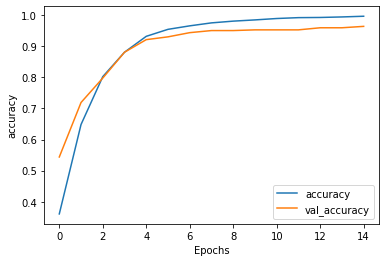

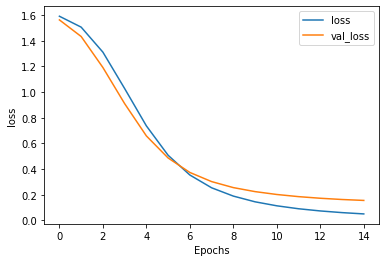

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model.layers[0].get_weights()

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 

(3000, 16)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in data_prep_pipe.named_steps['text_2_sequence'].words_indices.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')